# ATLAS Open Event Generation

ATLAS has released a significant amount of [event generator output](https://opendata.atlas.cern/docs/data/for_research/evgen_data) as open data, in HEPMC2 format. This notebook shows a simple example of how to work with those open data.

## Initialization

We'll start by installing a couple of key packages using `pip`:
* [atlasopenmagic](https://opendata.atlas.cern/docs/atlasopenmagic) provides convenient access to metadata and file locations
* [pyhepmc](https://scikit-hep.org/pyhepmc/) provides convenient ways to play with HEPMC files
* [graphviz](https://pypi.org/project/graphviz/) provides cool visualization interfaces for the events

For the last section of this notebook, we'll use a parametric detector simulation called [Delphes](http://delphes.github.io). It's commonly used for phenomenology studies, and has a lot of nice features that we'll only just touch here, but you should feel free to explore further on your own!

As you'll see in the log, it may be that you need to restart the kernel after installing these packages for the first time in order to get everything in working order. In case you encounter some odd error (cannot import a module, or cannot find a package) later in this notebook, try restarting the kernel to see if that solves your issue.

In [ ]:
# Pip installs first
%pip install atlasopenmagic pyhepmc graphviz
# Now conda installs
%conda install --channel conda-forge delphes

## Finding and downloading a file to work with

We'll start from atlasopenmagic and set it up to load the open event generation data.

In [ ]:
import atlasopenmagic as atom
atom.set_release('2025r-evgen')

Let's grab a file to play with from one of our open generation datasets. You can pick any dataset from those listed on the [Open Data Portal](https://opendata.cern/record/160000).

In [ ]:
# We'll print all the metadata from the sample (cross section, k-factor, etc)
print(atom.get_metadata('301000'))
# Get the URLs for the files in the dataset. We disable caching because we are
# going to download the files ourselves, by hand
my_urls = atom.get_urls('301000', protocol='https', cache=False)
print(f'Will test with file {my_urls[0]}')

Now let's download that file locally. The files are about 500 MB, which takes about a minute to get to the node most of the time.

In [ ]:
# Pull down the entire file using urllib's request functionality
import urllib.request
(local_filename,headers) = urllib.request.urlretrieve(my_urls[0])
# Use tarfile to get the HEPMC file out of the tar.gz file
import tarfile
with tarfile.open(local_filename, mode="r:gz") as tar_file:
    # There should be only one member - our hepmc file
    hepmc_file = tar_file.getmembers()[0]
    # Extract it!
    tar_file.extract(hepmc_file, filter='data')
print(f'Extracted {hepmc_file.name} from the tarfile')

## Using pyhepmc to inspect the events

First we'll do something very simple: **open the file and print the first event
in text form**. These text-form events are *very long*, but with some practice
they can be "easy" to read. A vertex (Vtx) represents a single interaction
in a tree-like structure, and each vertex has a list of particles that are
input ("I") and output ("O"). Every vertex, and every particle, has a status
that says something about how it was produced or what it means. For example,
particles with `status==1` are "stable" and will enter the detector.

In [ ]:
import pyhepmc
# We'll also import graphviz for visualization
import graphviz
# Open the file itself
my_hepmc = pyhepmc.open(hepmc_file.name)
# Read the first event out of the file
my_first_event = my_hepmc.read()
# Using 'print' prints the event in ASCII format
print(my_first_event)

## Visualize events with pyhepmc and graphviz

All you have to do is have jupyter try to display the event, and with graphviz it
will display a graph. Note that colab requires some effort to get the graph to
display properly with graphviz.

This is a huge graph! Feel free to play with the visualization following some of the
[pyhepmc visualization tutorial](https://scikit-hep.org/pyhepmc/examples/basics.html).

In [ ]:
# Use graphviz to visualize the graph
my_first_event

## Examining the particles in the event

Let's look at just the first 15 particles.

We'll be able to see the incoming protons, as well as various particles involved in
the collision. Notice that the two incoming protons in the collision are *not*
necessarily the first and second particles in the event! In this particular case,
they're the first and 11th! Any analysis of these kinds of
events always takes a bit of care, because the event records might not look the way
you would naively expect. It's always good to check your assumptions carefully.

In [ ]:
# Print the first 15 particles
my_first_event.particles[:15]

Now let's look at some of the vertices. A vertex can often be thought of as representing a single interaction, like the decay of a particle. Here's a simple little function that will print the vertex information in a reasonably pretty way:

In [8]:
# Helper function to print vertices and their incoming and outgoing particles
def print_vertex(event, vertex_number):
    print(f'Vertex {vertex_number}: {event.vertices[vertex_number]}')
    print('Incoming particle list:')
    for n,p in enumerate(event.vertices[vertex_number].particles_in):
        print(f'   Particle {n}: {p}')
    print('Outgoing particle list:')
    for n,p in enumerate(event.vertices[vertex_number].particles_out):
        print(f'   Particle {n}: {p}')

Vertices have a time and position, and particles have a momentum, energy, mass, particle ID (`pid`) and status. The particle ID is standardized across all generators; a group called the Particle Data Group keeps a [review explaining and listing particle IDs](http://pdg.lbl.gov/2024/reviews/rpp2024-rev-monte-carlo-numbering.pdf). Because the event generator used to create these events is Pythia8, we can look into the [Pythia8 documentation](https://pythia.org/latest-manual/ParticleProperties.html) to see what status codes it uses. Only a few status codes are standard across all generators:
- Status code 1 means "stable particle"; that propagation of that particle through the detector should be simulated.
- Status code 2 means "particle decayed"; there will be decay products that the generator (Pythia8 in this case) created.
- Status code 3 means "documentation particle"; these are entires in the event record that the authors wanted to keep to help document what happened in the event, but they should not necessarily be considered part of any kind of physical event interpretation.

There are _many_ other status codes used in some generators like Pythia. 

For educational purposes we've picked out a few interesting vertices from the first event in the file this notebook uses by default. In case you load a different file or dataset, you might find different vertex properties or numbers of vertices. First, let's look at vertex number 465.

In [ ]:
print_vertex(my_first_event,465)

That's a nice example of a decay vertex. You can look up the `pid` mapping in the Particle Data Group guide; this particular vertex has a $K^*\rightarrow K^+\pi^-$ decay (notice that the negative `pid` means that it has the opposite charge from what's listed in the Particle Data Group table). You can see that the $K^*$ has `status=2`, meaning it decays, and both the $K^+$ and $\pi^-$ have `status=1`, meaning that they are stable and will fly into the detector.

Next, let's look at vertex number 100.

In [ ]:
print_vertex(my_first_event,100)

That's an interesting looking vertex - only one particle in, and one particle out! In this case, the status code of the particle changed, from 62 to 71. We can see in the Pythia8 documentation that these are two different representations of the same particle; in the second case the particle is being prepared for "hadronization" (the process of taking all the particles like quarks and gluons that are produced in the original collision and turning them into the hadrons that we observe in our detectors). This is another reason that looking through these event records is tricky: sometimes we are looking at different views of the same particle, and not all of them are really "physical".

Finally, let's look at vertex number 327.

In [ ]:
print_vertex(my_first_event,327)

Wow, that's a weird looking vertex! This is an example of a hadronization vertex, where some of the particles that were produced in the original collision have been gathered together to form hadrons. You can see that some of those hadrons are stable, and some of them decay before they reach the detector. 

In our minds, we often have a simplified view of an event generator record as a tree, where one particle becomes two, and two become four, as they produce radiation and decay. The above examples show us that things can be a lot more complicated than that, and considerable care is required when studying the internals of the particle records. It's usually safest to look at the stable particles (with `status=1`), because those are the particles that the generator believes will enter the detector. They are what we refer to as "observable". Often when trying to look into things that are not observable (e.g. particles with other status codes), the answer becomes dependent on the implementation of the event generator, or what the event generator authors chose to write into the HEPMC record — and of course, nature can't depend on what an event generator author decided to do!

Feel free to look at other particles or vertices, or records from other events if you would like.

## Building histograms from the HEPMC record

Now we'll make a couple of simple histograms by looping over all the events in the file and calculating a few event properties. We'll use the `hist` library, which is a convenient python library for histogramming.

These are di-electron Drell-Yan events, which means we should expect them to almost always have a high-momentum electron and a high-momentum positron. We will look at the mass and momentum of that pair of particles in this example. You can read from the dataset name that we expect the mass to be between 120 and 180 GeV. Notice that we pick out the `status==1` particles, which are the ones that are stable. The status code allows a physicist to pick particles at different stages of the calculation that was used to produce the event.

Here we'll also do a quick conversion, because the particle energies in the file are stored in `MeV`, and we'll draw them in `GeV`.

In [12]:
import hist # Useful library for histogramming
# We will make histograms of the mass and pT of the Drell-Yan events
m_hist = hist.Hist(hist.axis.Regular(40, 120, 180, label="DY mass [GeV]"))
pt_hist = hist.Hist(hist.axis.Regular(40, 0, 200, label="DY p_{T} [GeV]"))
# Open the HEPMC file
with pyhepmc.open(hepmc_file.name) as my_hepmc_input:
    # And loop through all the events
    for event in my_hepmc_input:
        # Because these are Drell-Yan di-electron events, we'll look for the highest transverse-momentum electrons
        electrons = [p for p in sorted(event.particles, key=lambda p:p.momentum.pt()) if abs(p.pid) == 11 and p.status==1]
        # In case we didn't find two electrons that are stable, just keep going
        if len(electrons)<2:
            continue
        # Fill in the histograms with the mass and momentum (with the right units!)
        m_hist.fill((electrons[0].momentum+electrons[1].momentum).m()/1000.)
        pt_hist.fill((electrons[0].momentum+electrons[1].momentum).pt()/1000.)

Now we can draw the histograms using matplotlib and numpy, two commonly-used python libraries for histogram making and manipulating arrays of numbers.

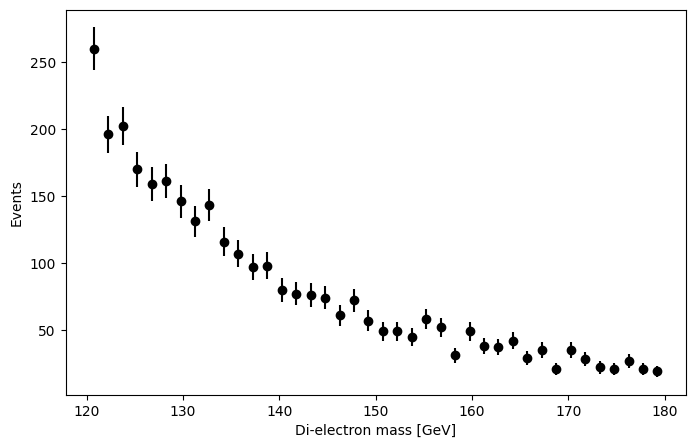

In [13]:
import matplotlib.pyplot as plt
import numpy as np
# Create a canvas that we'll draw the plot on
fig, ax = plt.subplots(figsize=(8, 5))
# Convert the hist histogram into numpy arrays
y, bin_edges = m_hist.to_numpy()
# Calculate a statistical uncertainty on the points
yerr = np.sqrt(y)
# Slightly awkward - convert from bin edges, which is what hist gives us, into bin centers, which is what matplotlib wants
x = [ (bin_edges[n]+bin_edges[n+1])/2. for n in range(len(bin_edges)-1) ]
# Now we can create the actual plot of our data
ax.errorbar(x=x, y=y, yerr=yerr,
                    fmt='ko', # 'k' means black and 'o' is for circles
                    label='Data')
# Set some labels to make it more clear what the plot shows
ax.set_xlabel("Di-electron mass [GeV]")
ax.set_ylabel("Events")
# And finally, do the drawing
plt.show()

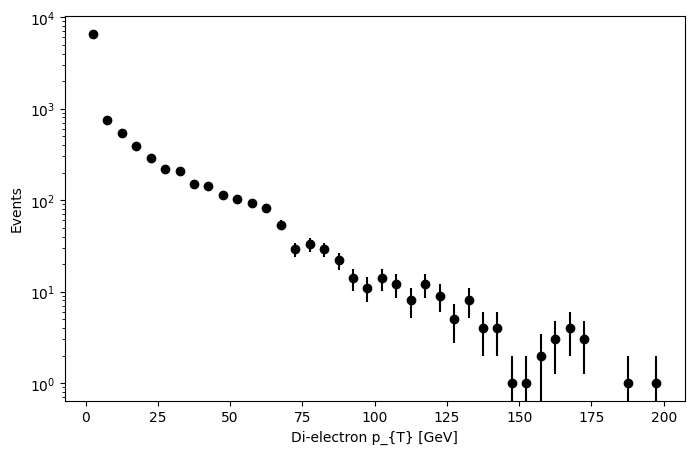

In [14]:
# And we can draw the transverse momentum plot as well
# This follows the same structure as in the previous cell
fig, ax = plt.subplots(figsize=(8, 5))
y, bin_edges = pt_hist.to_numpy()
yerr = np.sqrt(y)
x = [ (bin_edges[n]+bin_edges[n+1])/2. for n in range(len(bin_edges)-1) ]
ax.errorbar(x=x, y=y, yerr=yerr,
                    fmt='ko', # 'k' means black and 'o' is for circles
                    label='Data')
ax.set_xlabel("Di-electron p_{T} [GeV]")
ax.set_ylabel("Events")
# We'll use a log y-axis so that the full graph is more visible
ax.set_yscale('log')
plt.show()

Feel free to play yourself and develop your own (more complex) usage for our HEPMC files! If you want to use pyhepmc, there are plenty of [examples available](https://scikit-hep.org/pyhepmc/examples.html).

## Detector Simulation

We can do some simple detector simulation using [Delphes](https://github.com/delphes/delphes) as well. Delphes is a pretty standard parametric detector simulation package used widely in the phenomenology community. Delphes offers some command-line executables that can be used. We will run one of the pre-defined analyses as an example. Of course, more complicated usage is possible!

There's a fair bit of magic in the next line. First, we're using `%%bash` magic in jupyter to let us run a command like we had a terminal with a `bash` shell. Delphes doesn't have a python interface, so we have to use it like an executable. Notice that we are passing the HEPMC file name through the bash magic here. The actual executable we are running is called `DelphesHepMC2`. Since these open event generation files are in `HepMC2` text format, that's the right executable to use. We access the "cards", which are for configuration, using the environment variable `${CONDA_PREFIX}`. That's where they all get installed, because we used conda up at the top of this notebook to install Delphes. There are a [lot of cards](https://github.com/delphes/delphes/tree/master/cards) available; here we're using the default ATLAS card. The next two arguments are the output file name (`delphes_output.root`) and the input file name (`$1` refers back to the HEPMC file name that we passed via the bash magic).

In [ ]:
%%bash -s {hepmc_file.name}
DelphesHepMC2 ${CONDA_PREFIX}/cards/delphes_card_ATLAS.tcl delphes_output.root $1

Let's examine the output of our Delphes run. It is written into a ROOT file, so just like in our other analyses we can look at it using uproot!

In [ ]:
import uproot # for reading .root files
# Get the tree with our data directly from the ROOT file
tree = uproot.open("delphes_output.root:Delphes")
# Just for an example here, we'll print the transverse momenta of the electrons
tree["Electron.PT"].arrays()

It's just that easy! From here, we can do anything that's been done from our [analysis notebooks](https://opendata.atlas.cern/docs/category/analysis-notebooks)!